In [ ]:
!pip install nltk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import warnings 
warnings.filterwarnings(action='ignore')
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import nltk
%config InlineBackend.figure_format = 'svg' # plots look nicer in svg
%matplotlib inline

#파일 불러오기
train_csv = pd.read_csv('/content/drive/MyDrive/Project/NLP/data/train.csv', encoding = 'utf-8')
test_csv = pd.read_csv('/content/drive/MyDrive/Project/NLP/data/test_x.csv', encoding = 'utf-8')
sample_submission = pd.read_csv('/content/drive/MyDrive/Project/NLP/data/sample_submission.csv', encoding = 'utf-8')

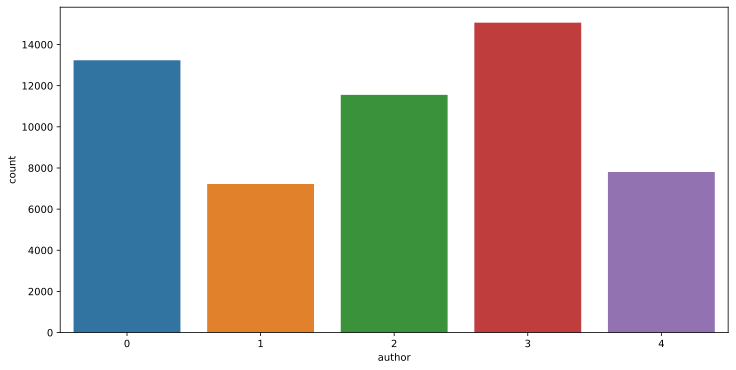

In [ ]:
# 작가별 데이터 분포 분석
sns.countplot(x="author", data=train_csv);

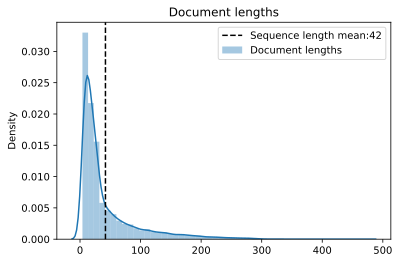

 가장 긴 문장: 471 개, 가장 짧은 문장: 4 개의 단어를 가지고 있음.


In [ ]:
# 문장 길이 분포도 확인
train_csv['doc_len'] = train_csv.text.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    mean_seq_len = np.round(dataframe.doc_len.mean()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장: {train_csv['doc_len'].max()} 개, 가장 짧은 문장: {train_csv['doc_len'].min()} 개의 단어를 가지고 있음.")

plot_doc_lengths(train_csv)

In [ ]:
# 작가별 문장 길이 시각화
train_csv["n_char"] = train_csv["text"].map(lambda x: len(x))
print(train_csv["n_char"].describe(), end='\n\n')
print(train_csv[train_csv["n_char"] == 2500]["text"].values, end='\n\n')
train_csv.head(10)

count    54879.000000
mean       228.115563
std        276.293793
min          9.000000
25%         63.000000
50%        118.000000
75%        265.000000
max       2500.000000
Name: n_char, dtype: float64

[' and a heavy shower of rain came on, too, and odin, insulted and put to shame, had to drive with a peasant in an open cart all the seventeen versts into town. only think now what answer could i have sent to the letter i received from you two months ago and what could i have written? i was in despair; i dared not write to you the truth because you would have been very unhappy, mortified and indignant, and yet what could you do? you could only perhaps ruin yourself, and, besides, odin would not allow it; and fill up my letter with trifles when my heart was so full of sorrow, i could not. for a whole month the town was full of gossip about this scandal, and it came to such a pass that odin and i dared not even go to church on account of the contemptuous looks, whispers, and even remar

,index,text,author,doc_len,n_char,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text
0,0,"he was almost choking. there was so much, so m...",3,46,240,"[he, was, almost, choking, there, was, so, muc...","[almost, choking, much, much, wanted, say, str...","[almost, choking, much, much, wanted, say, str...","[almost, choke, much, much, want, say, strang,..."
1,1,"“your sister asked for it, i suppose?”",2,7,38,"[your, sister, asked, for, it, i, suppose, ?]","[sister, asked, suppose, ?]","[sister, asked, suppose, ?]","[sister, ask, suppos, ?]"
2,2,"she was engaged one day as she walked, in per...",1,57,320,"[she, was, engaged, one, day, as, she, walked,...","[engaged, one, day, walked, perusing, jane, la...","[engaged, one, day, walked, perusing, jane, la...","[engag, one, day, walk, perus, jane, last, let..."
3,3,"the captain was in the porch, keeping himself ...",4,58,319,"[the, captain, was, in, the, porch, keeping, h...","[captain, porch, keeping, carefully, way, trea...","[captain, porch, keeping, carefully, way, trea...","[captain, porch, keep, care, way, treacher, sh..."
4,4,"“have mercy, gentlemen!” odin flung up his han...",3,39,228,"[have, mercy, gentlemen, !, odin, flung, up, h...","[mercy, gentlemen, !, odin, flung, hands, writ...","[mercy, gentleman, !, odin, flung, hand, write...","[merci, gentleman, !, odin, flung, hand, write..."
5,5,"""it was well fought,"" he said, ""and, by my soo...",4,16,81,"[it, was, well, fought, he, said, and, by, my,...","[well, fought, said, sooth, charge, us, twice]","[well, fought, said, sooth, charge, u, twice]","[well, fought, said, sooth, charg, u, twice]"
6,6,"not to pay him was impossible, considering his...",3,23,133,"[not, to, pay, him, was, impossible, consideri...","[pay, impossible, considering, character, talk...","[pay, impossible, considering, character, talk...","[pay, imposs, consid, charact, talk, fellow, p..."
7,7,"“a proper figure of a man at-arms,” said the l...",2,77,387,"[a, proper, figure, of, a, man, atarms, said, ...","[proper, figure, man, atarms, said, little, kn...","[proper, figure, man, atarms, said, little, kn...","[proper, figur, man, atarm, said, littl, knigh..."
8,8,"'you were not here last sunday night,' he said.",0,9,47,"[you, were, not, here, last, sunday, night, he...","[last, sunday, night, said]","[last, sunday, night, said]","[last, sunday, night, said]"
9,9,“you must not ask me that!” i cried. “hell may...,4,32,172,"[you, must, not, ask, me, that, !, i, cried, h...","[must, ask, !, cried, hell, may, noble, flames...","[must, ask, !, cried, hell, may, noble, flame,...","[must, ask, !, cri, hell, may, nobl, flame, kn..."


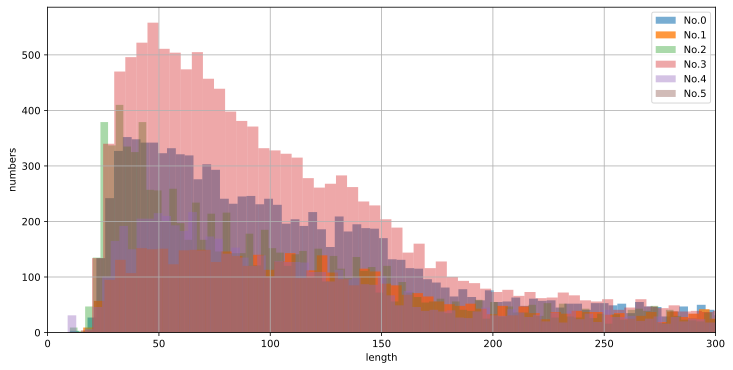

In [ ]:
import matplotlib
from matplotlib import pyplot as plt

n0_data = train_csv[train_csv['author'] == 0]
n1_data = train_csv[train_csv['author'] == 1]
n2_data = train_csv[train_csv['author'] == 2]
n3_data = train_csv[train_csv['author'] == 3]
n4_data = train_csv[train_csv['author'] == 4]
n5_data = train_csv[train_csv['author'] == 5]

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 500
plt.hist(n0_data['n_char'], alpha = 0.6, bins=bins, label='No.0')
plt.hist(n1_data['n_char'], alpha = 0.8, bins=bins, label='No.1')
plt.hist(n2_data['n_char'], alpha = 0.4, bins=bins, label='No.2')
plt.hist(n3_data['n_char'], alpha = 0.4, bins=bins, label='No.3')
plt.hist(n4_data['n_char'], alpha = 0.4, bins=bins, label='No.4')
plt.hist(n5_data['n_char'], alpha = 0.4, bins=bins, label='No.5')

plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')

plt.xlim(0,300)
plt.grid()
plt.show()

(0.0, 500.0)

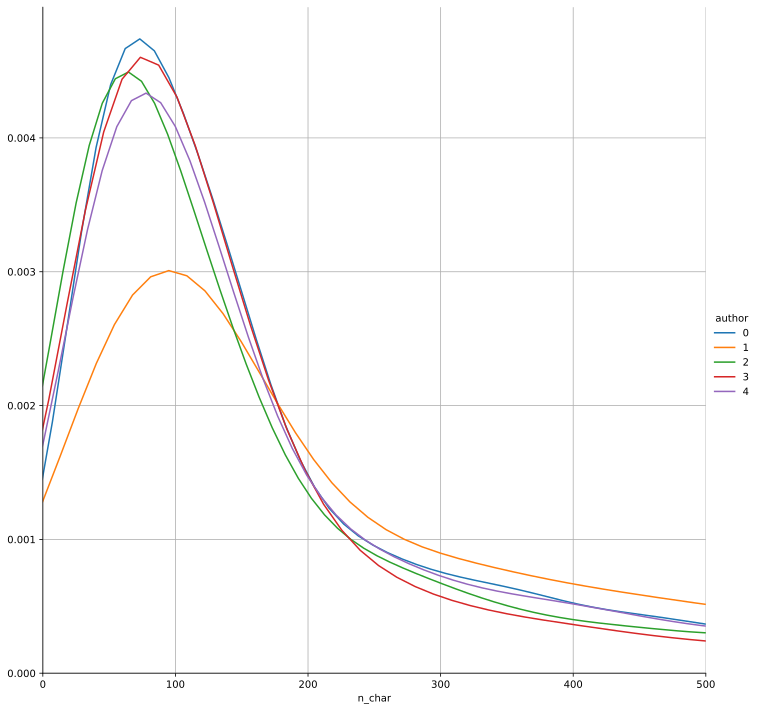

In [ ]:
# 작가별 문장 길이 시각화
sns.FacetGrid(train_csv, hue = "author", size = 10) \
   .map(sns.kdeplot, "n_char") \
   .add_legend()

plt.grid()
plt.xlim(0, 500)

각 작가들 마다 데이터 분포가 일치하므로 예측 모델링의 특징으로 텍스트 길이를 생략하는 것이 좋다.

### Q2. 작가별로 자주 쓰이는 단어가 있을까?

문장의 단어 분포도
-> 어떤 단어가 많이 등장했나?

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


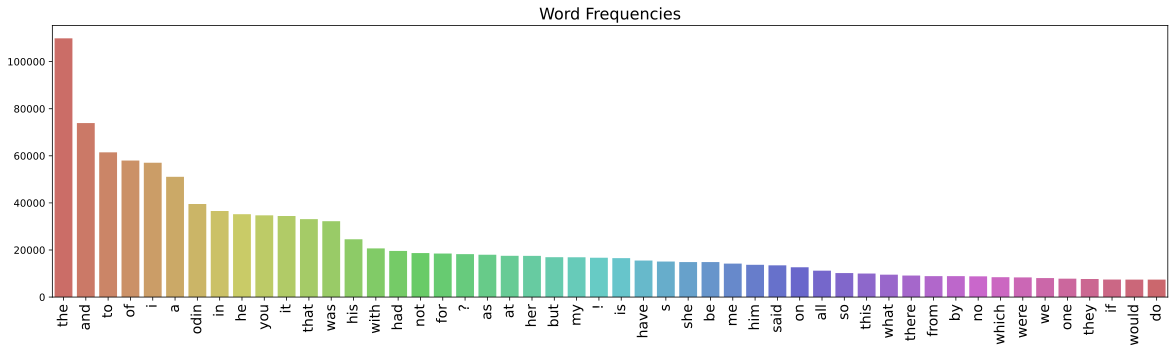

In [ ]:
"""단어 빈도 - 토큰화"""
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

"""단어 빈도"""
nltk.download('punkt')
def lda_get_good_tokens(df):
    df['text'] = df.text.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.text))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(train_csv)


from collections import Counter

tokenized_only_dict = Counter(np.concatenate(train_csv.tokenized_text.values))

tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)
tokenized_only_df.sort_values('count', ascending=False, inplace=True)

# I made a function out of this since I will use it again later on 
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(tokenized_only_df)
ax.set_title("Word Frequencies", fontsize=16);

Q2. 작가별로 자주 쓰이는 단어가 있을까?

2-1)
문장의 단어 분포도 -> 어떤 단어가 많이 등장했나?


2-2)
 위 데이터 중, 작가들의 사용 빈도는?

In [ ]:
nltk.download('stopwords')

our_special_word = 'qwerty'
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('english')
    # we'll add our own special word in here 'qwerty'
    stopwords.append(our_special_word)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(train_csv)

#
nltk.download('wordnet')
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(train_csv)

#
from gensim.corpora import Dictionary
dictionary = Dictionary(documents=train_csv.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

dictionary.filter_extremes(no_above=0.8, no_below=3)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Found 26034 words.
Left with 12534 words.


In [ ]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

cleansed_words_df.sort_values('count', ascending=False, inplace=True)

n0_words = list(np.concatenate(train_csv.loc[train_csv.author == 0, 'stemmed_text'].values))
n1_words = list(np.concatenate(train_csv.loc[train_csv.author == 1, 'stemmed_text'].values))
n2_words = list(np.concatenate(train_csv.loc[train_csv.author == 2, 'stemmed_text'].values))
n3_words = list(np.concatenate(train_csv.loc[train_csv.author == 3, 'stemmed_text'].values))
n4_words = list(np.concatenate(train_csv.loc[train_csv.author == 4, 'stemmed_text'].values))

n0_word_frequencies = {word: n0_words.count(word) for word in cleansed_words_df.index[:50]}
n1_word_frequencies = {word: n1_words.count(word) for word in cleansed_words_df.index[:50]}
n2_word_frequencies = {word: n2_words.count(word) for word in cleansed_words_df.index[:50]}
n3_word_frequencies = {word: n3_words.count(word) for word in cleansed_words_df.index[:50]}
n4_word_frequencies = {word: n4_words.count(word) for word in cleansed_words_df.index[:50]}

frequencies_df = pd.DataFrame(index=cleansed_words_df.index[:50])

frequencies_df['n0_freq'] = list(map(lambda word:
                                      n0_word_frequencies[word],
                                      frequencies_df.index))

frequencies_df['n0_n1_freq'] = list(map(lambda word:
                                          n0_word_frequencies[word] + n1_word_frequencies[word],
                                          frequencies_df.index))

frequencies_df['n0_n1_n2_freq'] = list(map(lambda word:
                                              n0_word_frequencies[word] + n1_word_frequencies[word] + n2_word_frequencies[word],
                                              frequencies_df.index))

frequencies_df['n0_n1_n2_n3_freq'] = list(map(lambda word:
                                              n0_word_frequencies[word] + n1_word_frequencies[word] + n2_word_frequencies[word] + n3_word_frequencies[word],
                                              frequencies_df.index))

frequencies_df['n0_n1_n2_n3_n4_freq'] = list(map(lambda word:
                                              n0_word_frequencies[word] + n1_word_frequencies[word] + n2_word_frequencies[word] + n3_word_frequencies[word] + n4_word_frequencies[word],
                                              frequencies_df.index))

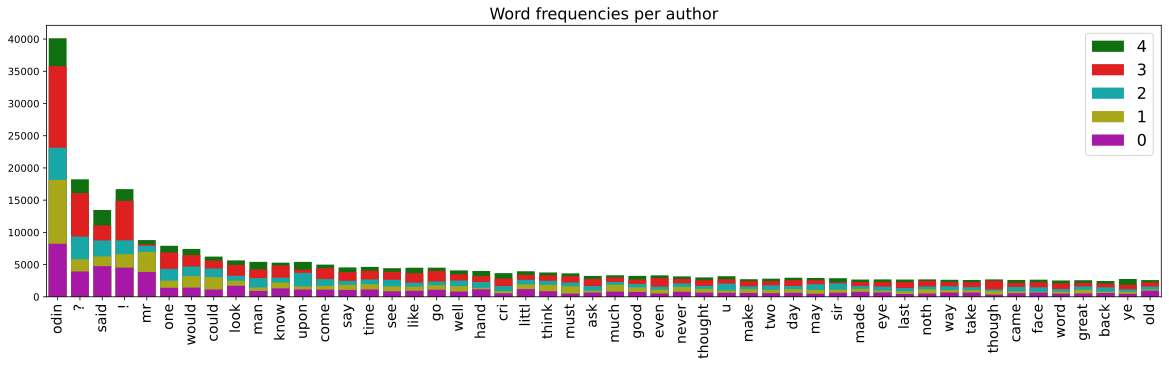

In [ ]:
# 작가별 단어 빈도

fig, ax = plt.subplots(1,1,figsize=(20,5))

nr_top_words = len(frequencies_df)
nrs = list(range(nr_top_words))
sns.barplot(nrs, frequencies_df['n0_n1_n2_n3_n4_freq'].values, color='g', ax=ax, label="4")
sns.barplot(nrs, frequencies_df['n0_n1_n2_n3_freq'].values, color='r', ax=ax, label="3")
sns.barplot(nrs, frequencies_df['n0_n1_n2_freq'].values, color='c', ax=ax, label="2")
sns.barplot(nrs, frequencies_df['n0_n1_freq'].values, color='y', ax=ax, label="1")
sns.barplot(nrs, frequencies_df['n0_freq'].values, color='m', ax=ax, label="0")

ax.set_title("Word frequencies per author", fontsize=16)
ax.legend(prop={'size': 16})
ax.set_xticks(nrs)
ax.set_xticklabels(frequencies_df.index, fontsize=14, rotation=90);

In [ ]:
## 작가별 Most 단어

cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

cleansed_words_df.sort_values('count', ascending=False, inplace=True)

n0_words = list(np.concatenate(train_csv.loc[train_csv.author == 0, 'stemmed_text'].values))
n1_words = list(np.concatenate(train_csv.loc[train_csv.author == 1, 'stemmed_text'].values))
n2_words = list(np.concatenate(train_csv.loc[train_csv.author == 2, 'stemmed_text'].values))
n3_words = list(np.concatenate(train_csv.loc[train_csv.author == 3, 'stemmed_text'].values))
n4_words = list(np.concatenate(train_csv.loc[train_csv.author == 4, 'stemmed_text'].values))

n0_word_frequencies = {word: n0_words.count(word) for word in cleansed_words_df.index[:50]}
n1_word_frequencies = {word: n1_words.count(word) for word in cleansed_words_df.index[:50]}
n2_word_frequencies = {word: n2_words.count(word) for word in cleansed_words_df.index[:50]}
n3_word_frequencies = {word: n3_words.count(word) for word in cleansed_words_df.index[:50]}
n4_word_frequencies = {word: n4_words.count(word) for word in cleansed_words_df.index[:50]}

frequencies_df = pd.DataFrame(index=cleansed_words_df.index[:50])

frequencies_df['n0_freq'] = list(map(lambda word:
                                      n0_word_frequencies[word],
                                      frequencies_df.index))

frequencies_df['n1_freq'] = list(map(lambda word:
                                          n1_word_frequencies[word],
                                          frequencies_df.index))

frequencies_df['n2_freq'] = list(map(lambda word:
                                              n2_word_frequencies[word],
                                              frequencies_df.index))

frequencies_df['n3_freq'] = list(map(lambda word:
                                              n3_word_frequencies[word],
                                              frequencies_df.index))

frequencies_df['n4_freq'] = list(map(lambda word:
                                              n4_word_frequencies[word],
                                              frequencies_df.index))

In [ ]:
## 작가별 Most 단어 plot

fig, ax = plt.subplots(5,1,figsize=(20,25))

nr_top_words = len(frequencies_df)
nrs = list(range(nr_top_words))

ax1 = plt.subplot(5, 1, 1)
sns.barplot(x=frequencies_df.sort_values('n0_freq', ascending=False).index, y=frequencies_df.sort_values('n0_freq', ascending=False)['n0_freq'].values, ax = ax1)

ax2 = plt.subplot(5, 1, 2)
sns.barplot(x=frequencies_df.sort_values('n1_freq', ascending=False).index, y=frequencies_df.sort_values('n1_freq', ascending=False)['n1_freq'].values, ax = ax2)

ax3 = plt.subplot(5, 1, 3)
sns.barplot(x=frequencies_df.sort_values('n2_freq', ascending=False).index, y=frequencies_df.sort_values('n2_freq', ascending=False)['n2_freq'].values, ax = ax3)

ax4 = plt.subplot(5, 1, 4)
sns.barplot(x=frequencies_df.sort_values('n3_freq', ascending=False).index, y=frequencies_df.sort_values('n3_freq', ascending=False)['n3_freq'].values, ax = ax4)

ax5 = plt.subplot(5, 1, 5)
sns.barplot(x=frequencies_df.sort_values('n4_freq', ascending=False).index, y=frequencies_df.sort_values('n4_freq', ascending=False)['n4_freq'].values, ax = ax5)

ax1.set_title("Word frequencies per author", fontsize=16)
ax1.legend(prop={'size': 16})
ax1.set_xticks(nrs)
ax1.set_xticklabels(frequencies_df.index, fontsize=14, rotation=90);

In [ ]:
# 불용어 제거
def remove_new_stopwords(text):
    token_text = nltk.word_tokenize(text)
    remove_stop = [word for word in token_text if word not in new_stop_words]
    join_text = ' '.join(remove_stop)
    return join_text

new_stop_data = train_csv.copy()

from itertools import chain

full_name = {0: 'Author0', 1: 'Author1', 2: 'Author2', 3: 'Author3', 4: 'Author4'}
writer_name = [0, 1, 2, 3, 4]

writer_count_obj = {'writer_full_name': [], 'total_words': [], 'unique_words': []}

for name in writer_name:
    name_all_words = new_stop_data[new_stop_data.author == name].text.str.split()
    name_merged = list(chain(*name_all_words))
    name_total_len = len(name_merged)
    myset = set(name_merged)
    
    writer_count_obj['writer_full_name'].append(full_name[name])
    writer_count_obj['total_words'].append(name_total_len)
    writer_count_obj['unique_words'].append(len(myset))

words_df = pd.DataFrame(writer_count_obj)
print(words_df, end='\n\n')

tidy = words_df.melt(id_vars='writer_full_name').rename(columns=str.title)
print(tidy)

  writer_full_name  total_words  unique_words
0          Author0       495038         42588
1          Author1       412520         30776
2          Author2       463233         39663
3          Author3       618136         44328
4          Author4       324628         36161

  Writer_Full_Name      Variable   Value
0          Author0   total_words  495038
1          Author1   total_words  412520
2          Author2   total_words  463233
3          Author3   total_words  618136
4          Author4   total_words  324628
5          Author0  unique_words   42588
6          Author1  unique_words   30776
7          Author2  unique_words   39663
8          Author3  unique_words   44328
9          Author4  unique_words   36161


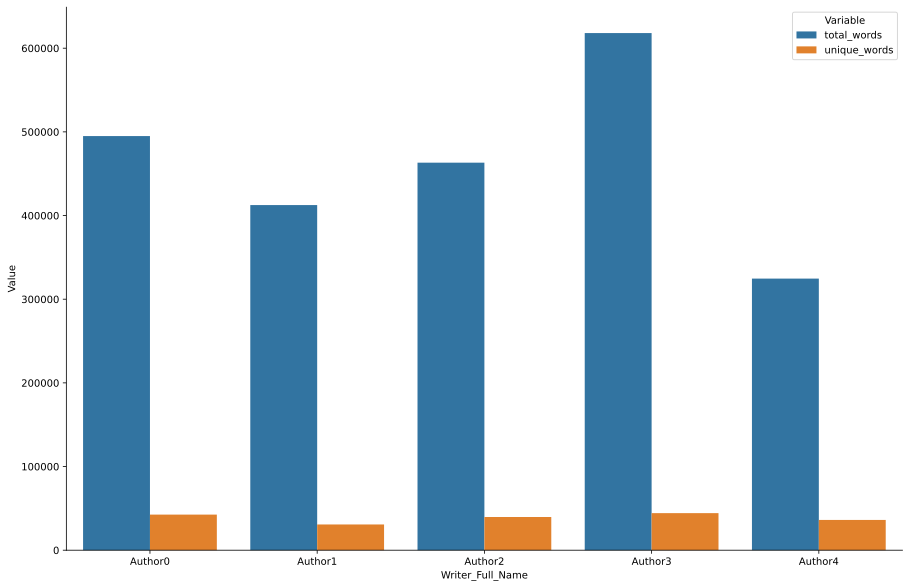

In [ ]:
# (작가별 사용한 total 단어 수 // 유니크한 단어의 개수)
fig, ax = plt.subplots(figsize=(15, 10))
tidy = words_df.melt(id_vars='writer_full_name').rename(columns=str.title)

sns.barplot(x='Writer_Full_Name', y='Value', hue='Variable', data=tidy, ax=ax)
sns.despine(fig)